<img src="https://raw.githubusercontent.com/cebirnie92/KAUST-Iraya_SummerSchool2021/main/figures/logo.jpg">

##**Day 3: Generating Embedding Vectors for Scientific Articles by BERT**

This tutorial focuses on 
1. generating embedding vectors for scientific articles by BERT 
2. visualize the embedding vectors of articles in two dimensions 
3. apply a clustering method to group the articles into different groups/clusters based on the similarity/difference between the embedding vectors.


We will play with 2044 articles in different fields, such as geoscience, biology, information system, and math. We have the article information including title, abstract, venue, and field. We aim to generate BERT embeddings of these articles such that the embedding vectors represent the articles by their content information. The vectors can be generated from the title of the articles, or from the combination of both title and abstract.


Practically, this tutorial is split into four parts:

1.   Applying text pre-processing to the titles to remove unnecessary words and symbols.
2.   Generating BERT embeddings for  each article using DistilBERT version of BERT.
3.   Visualizing BERT embeddings in 2-dim space by t-SNE to understand the overall distribution of the articles.
4.   Clustering the articles into four groups representing the articles fields, based on k-means clustering algorithm.

<img src="../figures/day3.png">

Please submit all results via https://docs.google.com/forms/d/e/1FAIpQLSdaLlUyztTJwu-it9EV77Fo8sPSK7FtWTjGB4S7gO5p6NlPFQ/viewform?usp=sf_link by 11:59pm GMT on 17 June 2021.


#**Notebook set-up**
**Installing all the packages that we will need for this tutorial** 

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.1MB/s 
     |████████████████████████████████| 3.3MB 28.9MB/s 
     |████████████████████████████████| 901kB 17.3MB/s 


In [ ]:
!pip install torch

#**Loading Data**

**Importing all required packages:**

In [ ]:
import os
import requests
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading biology, math, and information system articles**

In [ ]:
# Data directory
#data_dir = "../data/"
data_dir = '/content/drive/MyDrive/'  # Uncomment if running on CoLab

# Load vectors 
path = os.path.join(data_dir, 'articles_df.csv')
data_df = pd.read_csv(path, sep=",", error_bad_lines=False)
data_df

,id,title,venue,abstract,feild
0,519,Improving the performance of hierarchical clas...,"Evolutionary Computation, Machine Learning and...",In this paper we propose a new method to impr...,biology
1,520,Semantic Predications for Complex Information ...,Bioinformatics and Biomedicine,Many complex information needs that arise in b...,biology
2,521,A collaborative filtering approach to assess i...,International Conference on Bioinformatics,! § Comorbidity refers to the phenomenon th...,biology
3,522,Faster Algorithms for Optimal Multiple Sequenc...,IEEE/ACM Transactions on Computational Biology...,Multiple Sequence Alignment (MSA) is one of th...,biology
4,523,Predicting Thermophilic Nucleotide Sequences B...,International Conference on Bioinformatics and...,Knowledge of thermophilic mechanisms about som...,biology
...,...,...,...,...,...
1539,2058,An Operator-Stream-Based Scheduling Engine for...,Advances in Databases and Information Systems,"Since a decade, the database community researc...",information system
1540,2059,When the Wait Isn’t So Bad: The Interacting Ef...,Information Systems Research,Awhen moving from one page to another. This e...,information system
1541,2060,The analysis and management of non-canonical r...,Knowledge and Information Systems,Non-canonical requirement specifications refer...,information system
1542,2061,"Robustness, stability, recoverability, and rel...",Knowledge and Information Systems,Many real-world problems in Artificial Intelli...,information system


**Loading geoscience articles**

In [ ]:
# setup credentials
token = 'Token %s'%('$TOKEN') # copy-paste token
#token = 'Token %s'% os.environ['IRAYATOKEN']

geo_data = []
pages = range(1,12)
for p in pages:
    print('page: %u'%p)
    headers = {"Content-type": "application/json", 
               "Authorization": token}
    
    # fetch data - with page number: we have 11 pages in total
    r = requests.get("https://demo.atelier.irayaenergies.ai/data-tracker/extracted-info?page=%i"%p, headers=headers)
    data = r.json()
    data["data"][0]
    geo_data.append(data["data"])
    
geo_data = [item for sublist in geo_data for item in sublist]

page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7
page: 8
page: 9
page: 10
page: 11


In [ ]:
geo_data[0]

{'attributes': {'bbox': {},
  'classification': 'text',
  'created_at': '2021-06-07T23:13:52.459347',
  'doc_text': 'The phase and group velocity surfaces are essential for wave propagation in anisotropic media. These surfaces have certain features that, especially, for shear waves result in complications for modelling and inversion of recorded wavefields. To analyse wave propagation in an anisotropic model, it is important to identify these features in both the phase and group domains. We propose few characteristics for this analysis: the energy flux angle, decomposed in the polar and azimuth angle correction angles and enhancement factor, which is able to characterize both singularity points and triplication zones. The very simple equation that controls the triplications is derived in the phase domain. The proposed characteristics are illustrated for elastic and acoustic anisotropic models of different symmetry classes.',
  'doc_text_translated': None,
  'is_cli': False,
  'other_tag

In [ ]:
# create data frame for geo data that have id, title, venue, abstract
geo_document = pd.DataFrame(geo_data)
df1= geo_document[['id']]

other_col= geo_document['attributes'].tolist()
df = pd.DataFrame(other_col)
df2= df[['doc_text']]

other_col= df['remarks'].tolist()
df3 = pd.DataFrame(other_col)
df3= df3[['TITLE', 'CONFERENCE_NAME']]

geo_df = pd.concat([df1, df2, df3], axis=1)
geo_df= geo_df[['id', 'TITLE', 'CONFERENCE_NAME', 'doc_text']]
#change the column name
geo_df = geo_df.rename(columns = { 'TITLE': 'title', 'CONFERENCE_NAME':'venue', 'doc_text':'abstract'}, inplace = False)
geo_df['feild']='geoscience'
geo_df= geo_df[:500]
geo_df

,id,title,venue,abstract,feild
0,5360133c-6f45-4e2e-afd0-ea60723db0a3,Geometrical characteristics of phase and group...,N/A,The phase and group velocity surfaces are esse...,geoscience
1,ed9f7bf2-0d84-4f35-a5d2-5d5435369c42,Optimized experimental design for seismic full...,N/A,Optimized experimental design aims at reducing...,geoscience
2,e7983b59-7b98-474b-8441-e55d621e4d6b,Analysis of Near-Shore Investigation Data for ...,3rd Asia Pacific Meeting on Near Surface Geosc...,No Summary.,geoscience
3,d447dc5e-0e04-4bfb-b8f4-1e73a898551a,Landslide Investigation using Borehole and Mul...,3rd Asia Pacific Meeting on Near Surface Geosc...,This paper presents results of a landslide inv...,geoscience
4,c8723574-d472-481b-ab45-0619cdc75c5b,Demarcation of Safety Zones for Development at...,3rd Asia Pacific Meeting on Near Surface Geosc...,Development project at hilly area include the ...,geoscience
...,...,...,...,...,...
495,bff8f50b-1d07-44bd-891b-bb87eb723166,Common Opening Angle Migration/Inversion by Su...,8th International Congress of the Brazilian Ge...,We show that the technique of migration/invers...,geoscience
496,c2282ee2-5318-4d6a-a56f-e10a07e6b57c,In situ observation of electron temperature en...,8th International Congress of the Brazilian Ge...,In-situ measurements of the height variation o...,geoscience
497,9bd1fe6e-5b6a-4dbe-85e8-70fc20263553,3D Seismic Volume Rendering,8th International Congress of the Brazilian Ge...,Volume Visualization has become a very useful ...,geoscience
498,6e028742-db24-47e9-9d3d-36da92c55dfe,Numerical Moveout Estimation for Migration Vel...,12th International Congress of the Brazilian G...,"In migration velocity analysis (MVA), the resi...",geoscience


**Combining all articles togather**

In [ ]:
frames = [data_df, geo_df]
data= pd.concat(frames, axis=0, ignore_index=True)
data

,id,title,venue,abstract,feild
0,519,Improving the performance of hierarchical clas...,"Evolutionary Computation, Machine Learning and...",In this paper we propose a new method to impr...,biology
1,520,Semantic Predications for Complex Information ...,Bioinformatics and Biomedicine,Many complex information needs that arise in b...,biology
2,521,A collaborative filtering approach to assess i...,International Conference on Bioinformatics,! § Comorbidity refers to the phenomenon th...,biology
3,522,Faster Algorithms for Optimal Multiple Sequenc...,IEEE/ACM Transactions on Computational Biology...,Multiple Sequence Alignment (MSA) is one of th...,biology
4,523,Predicting Thermophilic Nucleotide Sequences B...,International Conference on Bioinformatics and...,Knowledge of thermophilic mechanisms about som...,biology
...,...,...,...,...,...
2039,bff8f50b-1d07-44bd-891b-bb87eb723166,Common Opening Angle Migration/Inversion by Su...,8th International Congress of the Brazilian Ge...,We show that the technique of migration/invers...,geoscience
2040,c2282ee2-5318-4d6a-a56f-e10a07e6b57c,In situ observation of electron temperature en...,8th International Congress of the Brazilian Ge...,In-situ measurements of the height variation o...,geoscience
2041,9bd1fe6e-5b6a-4dbe-85e8-70fc20263553,3D Seismic Volume Rendering,8th International Congress of the Brazilian Ge...,Volume Visualization has become a very useful ...,geoscience
2042,6e028742-db24-47e9-9d3d-36da92c55dfe,Numerical Moveout Estimation for Migration Vel...,12th International Congress of the Brazilian G...,"In migration velocity analysis (MVA), the resi...",geoscience


# **Text Pre-processing**

**Importing all required packages:**

In [ ]:
import nltk
nltk.download('punkt')

import string
import re
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Here we load English stopwords and punctuations to determine them in the text and remove them.**

In [ ]:
#Stopwords
nltk.download('stopwords')
en_stopwords = set(nltk.corpus.stopwords.words('english'))

#punctuation
english_punctuations = string.punctuation
punc_to_remove = ''.join(set(english_punctuations))
print(punc_to_remove)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/?)_>|{*^},"@-'(]&`;:=#[!$\~+.<%


**The following function 'pre_process(text)' removes numbers, punctuations, and stopwords from the input strings.**

In [ ]:
def pre_process(text):
    
    text = re.sub(r'\d+(\.\d+)?', ' number ', text)  # replace numbers by special token
    for p in punc_to_remove: text = text.replace(p, ' ')  # remove punctuations
    
    #Removing stopwords
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in en_stopwords]
    filtered_sentence = (" ").join(tokens_without_sw)
    text= filtered_sentence
    return text


**Applying text pre-processing to the titles**

In [ ]:
#befor processing 
prev_title = data['title'].tolist()

#Applaying text pre-processing
data['title'] = data['title'].apply(lambda x:pre_process(x))

#after processing 
after_title = data['title'].tolist()

In [ ]:
#to show before and after 
print(prev_title[10])
print(after_title[10])

Pathological Image Analysis Using the GPU: Stroma Classification for Neuroblastoma
Pathological Image Analysis Using GPU Stroma Classification Neuroblastoma


# **Generating BERT Embedding**

The details of using BERT model can be found at  [this tutorial](https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=ddAqbkoU6PP9)

**Import all required packages:**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

**DistilBERT**


We use here DistilBERT, which is a lighter version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.

We will first use the trained distilBERT to generate  embedding vectors for 2,044 articles (using the title sentence in the first setting), where the embeddings length is 768.

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

The above figure is from: https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=ddAqbkoU6PP9

In [ ]:
# # For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **Tokenization**

Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

The above figure is from: https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=ddAqbkoU6PP9

In [ ]:
#Tokenization
tokenized = data['title'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

0        [101, 9229, 2836, 25835, 5579, 21708, 4454, 102]
1       [101, 21641, 3653, 25027, 2015, 3375, 2592, 37...
2       [101, 1037, 12317, 22910, 3921, 14358, 3265, 4...
3       [101, 5514, 13792, 15502, 3674, 5537, 12139, 2...
4       [101, 29458, 1996, 10867, 7361, 19466, 2594, 1...
                              ...                        
2039    [101, 2691, 3098, 6466, 9230, 28527, 7680, 286...
2040    [101, 1999, 26179, 8089, 10496, 4860, 22415, 2...
2041           [101, 2193, 1040, 22630, 3872, 14259, 102]
2042    [101, 15973, 2693, 5833, 24155, 9230, 10146, 4...
2043    [101, 4646, 3746, 6364, 5461, 2093, 8789, 1164...
Name: title, Length: 2044, dtype: object

### **Padding**
After tokenization, `tokenized` is composed of a list of sentences -- each sentences is represented as a list of tokens. Since we want to use BERT to process our examples all at once (as one batch) for efficiency reason, we pad all lists to the same size. Thus we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
#Padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

#just if the text= tittle + abstract
padded= np.array([list(x[:512]) for x in padded])

np.array(padded).shape

(2044, 45)

Our dataset is now in the `padded` variable, we can view its dimensions below:


In [ ]:
padded

array([[  101,  9229,  2836, ...,     0,     0,     0],
       [  101, 21641,  3653, ...,     0,     0,     0],
       [  101,  1037, 12317, ...,     0,     0,     0],
       ...,
       [  101,  2193,  1040, ...,     0,     0,     0],
       [  101, 15973,  2693, ...,     0,     0,     0],
       [  101,  4646,  3746, ...,     0,     0,     0]])

### **Masking**
To inform BERT the   `padded` elements in the arrary, we create another variable  attention_mask:

In [ ]:
#Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2044, 45)

In [ ]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### **And Now, Deep Learning!**
Now that we have our model and inputs ready. Let's run our model!

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.


In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.


<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

The above figure is from: https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=ddAqbkoU6PP9

We'll save those in the `features` variable, as they'll be used as feature representations for the down stream tasks, such as classification and clustering. 

In [ ]:
#text embedding:

features = last_hidden_states[0][:,0,:].numpy()
features.shape

(2044, 768)

# **t-SNE Visualization of BERT Embeddings**

To visualize the embeddings in 2-dimension, we need to transform the vectors from 768-dimension to 2-dimension. This process is called "Dimensionality Reduction". There are many ways to do that, one of the most popular ways is by using t-SNE.


t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

**Import all required packages:**

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:

#Get t-SNE Representation
features_2d = TSNE(n_components=2).fit_transform(features)

**Since we have the representation of the embeddings in 2-dimension, we can now plot them.**

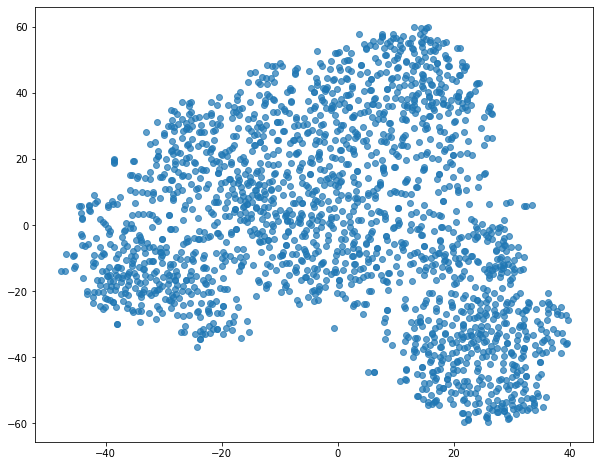

In [ ]:

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(features_2d[:, 0], features_2d[:, 1], alpha=.7);


**We can also plot the embeddings and show their corresponding fields**

In [ ]:
#This function to plot the embeddings with thier corresponding feilds
def plot_tSNE(labels_encoded,x):
    plt.figure(figsize=(10,10))
    for cl in sorted(set(labels_encoded)):
        indices = np.where(labels_encoded==cl)
        indices = indices[0]
        plt.scatter(x[indices,0], x[indices, 1], label=cl)

    plt.legend()
    plt.show()
    



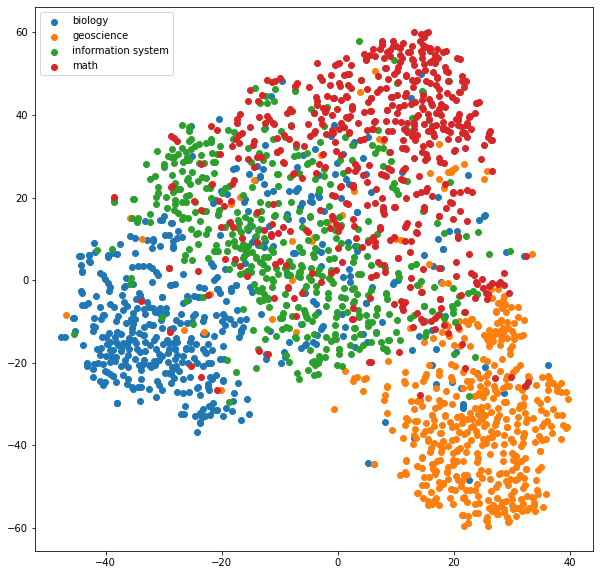

In [ ]:
actual_field = np.array(data['feild'].tolist() )
plot_tSNE(actual_field, features_2d)

#**Applying Clustering to BERT Embeddings**

**Clustering** is the task of dividing the data samples into several groups such that the samples in the same groups are more similar to other than those in other groups.


**K-means clustering algorithm** partition n observations into k clusters where each observation belongs to the cluster with the nearest mean serving as a prototype of the cluster.


In this part, we use the K-means clustering algorithm to assign different embeddings to different groups/clusters (we can determine the number of these clusters). Here we make the number of clusters equal to the number of the fields in the data to know the ability of the clustering algorithm to realize the similarity of the embeddings belonged to the same fields.



**Import all required packages:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

**Here we initialize k-means algorithm with proper hyperparameters, then fit it to the data, and predict cluster for each sample in the data**

In [ ]:
X= features
id = data['id'].tolist()


#initialize with proper hyperparameters 
kmeans = KMeans(
    n_clusters=4, init='k-means++',
    n_init=10, max_iter=500, 
    tol=1e-04, random_state=None
)

#fit k-means algorithm to the data
kmeans.fit(X)

#predict cluster of the data samples
pred_y = kmeans.predict(X)


### **Clustering Evaluation**

There are many evaluation metrics  for clustering. Here we use [NMI score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html), purity score, and show the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) 

**Importing required packages:**

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix


**Firstly, we need that each cluster reflects its actual field, we do that by making each clustering index equal to the majority of the fields belonged to it.**

In [ ]:
#Calculating majority
def most_frequent(List):
    return max(set(List), key = List.count)

In [ ]:
# Determine the indices of samples that belongs to each predicted cluster
index_list= []
for k in set(pred_y):
  index=[]
  for i in range(len(pred_y)):
    if pred_y[i]==k:
      index.append(i)
  index_list.append(index)

#The actual field for each indices list
True_y_list=[]
for k in index_list:
  true=[]
  for i in k:
    true.append(actual_field[i])
  True_y_list.append(true)

#Find the majority of actual field for each predicted cluster
majority=[]
for k in True_y_list:
   majority.append (most_frequent(k))

In [ ]:
majority

['math', 'geoscience', 'biology', 'information system']

In [ ]:
#Map predicted clusters (pred_y values) to the majority field in each class
pred_field = []
for i in range(len(pred_y)):
      if pred_y[i]==0:
          pred_field.append(majority[0])
      elif pred_y[i]==1:
          pred_field.append(majority[1])
      elif pred_y[i]==2:
          pred_field.append(majority[2])
      elif pred_y[i]==3:
          pred_field.append(majority[3])
  
pred_field= np.array(pred_field)   
    

**Visualizing the embedding with their corresponding predicted clusters**

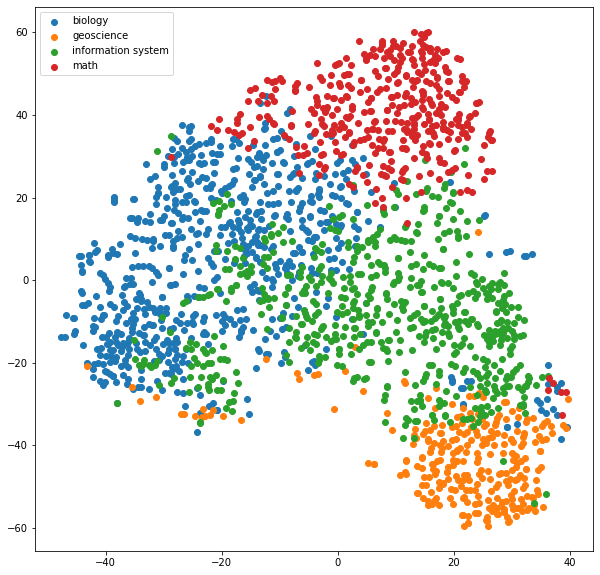

In [ ]:
plot_tSNE(pred_field, features_2d)

**NMI score:**

In [ ]:
nmi= normalized_mutual_info_score(actual_field, pred_field)
nmi

0.2876086361903184

**Purity score:**

In [ ]:

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [ ]:
purity_score(actual_field, pred_field)

0.5567514677103719

**Showing the confusion matrix:**

In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(actual_field, pred_field)
print(cf_matrix)

[[360  20 121  16]
 [ 35 262 184  19]
 [246   6 188  40]
 [ 82   0 137 328]]


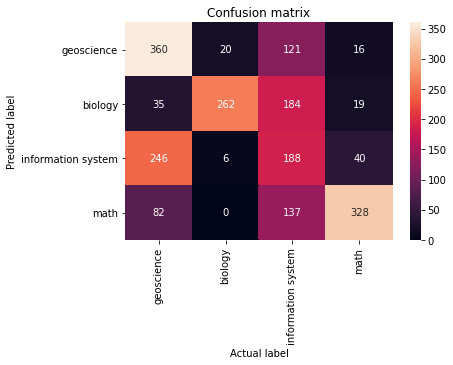

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.xticks([0.5,1.5,2.5,3.5],labels=['geoscience', 'biology', 'information system', 'math'], rotation=90)
plt.yticks([0.5,1.5,2.5,3.5],labels=['geoscience', 'biology', 'information system', 'math'], rotation=0)
plt.title('Confusion matrix')
plt.xlabel('Actual label')
plt.ylabel('Predicted label');

# **Practical Part**

**TODO Tasks:**


1.   In k-means algorithm, change the number of clusters to 10, 15, and 20, then show the clustering figures for each.
2.   In this tutorial, we use only title as text that represents papers. Try to combine both title and abstract, will this improve BERT Embedding? you can answer this question by showing BERT embeddings in two dimensions with their corresponding fields. 

#**Final Task**

<img src="../figures/day3.png">